<a href="https://colab.research.google.com/github/AlexeyKarz/food-models/blob/main/transef_learning_fast_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Food Vision 2.0 using Keras, TensorFlow and Transfer Learning

During this project same as in the [previous version]() I will build a multiclass image classification model using Keras API. But this time I will use transfer learning to use the advantage of pretrained models. For this project I used a subsed of food101 dataset. I extracted following classes from the original dataset using [this functions](https://github.com/AlexeyKarz/food-models/blob/main/food_helper_functions.py). The classes are:` 'chicken_wings' 'club_sandwich' 'donuts' 'french_fries' 'hamburger'
 'hot_dog' 'onion_rings' 'pizza' 'sushi' 'tacos'`

# Setting the workspace

Downloading the modules required for work

In [25]:
import datetime
import os
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

I will also import helper functions module from [here](https://github.com/AlexeyKarz/food-models/blob/main/extra/food_helper_functions.py)

In [2]:
!wget https://raw.githubusercontent.com/AlexeyKarz/food-models/main/extra/food_helper_functions.py
import food_helper_functions

--2023-12-07 13:42:59--  https://raw.githubusercontent.com/AlexeyKarz/food-models/main/extra/food_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8540 (8.3K) [text/plain]
Saving to: ‘food_helper_functions.py’

food_helper_functio 100%[===================>]   8.34K  --.-KB/s    in 0s      

2023-12-07 13:43:00 (113 MB/s) - ‘food_helper_functions.py’ saved [8540/8540]



In [3]:
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-12-07 13:43:01.044054


In [4]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.14.0


In [5]:
from google.colab import drive
drive.mount('/content/drive') # get access for google drive

Mounted at /content/drive


In [6]:
#check available devices
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


# Accessing the data

In [7]:
folder_path = '/content/drive/MyDrive/Projects/food101/fast_food_10_classes'


In [8]:
train_dir = "/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/"
test_dir = "/content/drive/MyDrive/Projects/food101/fast_food_10_classes/test/"

In [9]:
# Walking through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(folder_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes'.
There are 10 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/hamburger'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/french_fries'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/hot_dog'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/donuts'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/tacos'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/pizza'.
There are 0 directories and 750 images in '/content/drive/MyDri

## Donwloading 10% dataset for the train data



In [10]:
train_dir_10p = "/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train"

In [11]:
for dirpath, dirnames, filenames in os.walk(train_dir_10p):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 10 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_fo

In [12]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_wings' 'club_sandwich' 'donuts' 'french_fries' 'hamburger'
 'hot_dog' 'onion_rings' 'pizza' 'sushi' 'tacos']


## Preparing the data
**For 10% of the train data**

In [13]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir_10p,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Setting up the callbacks

One of the callbacks I will add to the models is Tensorboard Callback. Its creation function is defined in the `food_helper_functions` module.

In [14]:
from food_helper_functions import create_tensorboard_callback

I will also add the `ModelCheckpoint` callback

In [15]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

I will also create a function that creates a learning rate callback that decays the learning rate by 0.1 after 4 epochs.

In [16]:
def learning_rate_schedule(epoch, initial_lr=0.001):
    """
    Learning rate schedule function.

    Parameters:
    - epoch: Current epoch.
    - initial_lr: Initial learning rate.

    Returns:
    - lr: Updated learning rate.
    """
    decay_factor = 0.1
    if epoch < 7:
        return initial_lr
    else:
        return initial_lr * decay_factor

In [17]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)

# Creating models

Before getting to creating models and training them I wil set up mixed precision training to achieve higher speed of fitting the models

In [18]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16")
# mixed_precision.global_policy()

## Feature Extraction. Downloading models from TensorfFlow Hub

First, I will use two models from TensorFlow Hub:

1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.
3. [MobileNet V1](https://tfhub.dev/google/imagenet/mobilenet_v1_075_224/feature_vector/5) - neural network architecture for efficient on-device image classification. `mobilenet_v1_075` with a depth multiplier of 0.75

In [19]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# EfficientNetB0 feature vector V2 (B0, since we use (224,224) image size)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

# MobileNet V1 feature extractor
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_075_224/feature_vector/5"

I will create a function `create_model()` to make comparison of models faster.

In [20]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model

  Args:
    model_url (str): TF Hub feature extraction URL
    num_classes (int): Number of output neurons in
    output layer (number of target classes). Default = 10
  Returns:
    Keras Sequential model
  """
  # download the pretrained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) #i input image shape
  # create the model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model


### ResNetV250 architecture

First I will create th model with ResNetV250 architecture. I will use categorical_crossentropy as loss function, Adam optimnizer and accuracy as metric.

In [26]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

In [27]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Now I will train the model on the 10% of the whole data

In [28]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  #callbacks=food_helper_functions.create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                              #experiment_name="resnet50V2")
                                                                                              )

Epoch 1/5
24/24 [==============================] - 1659s 71s/step - loss: 1.9411 - accuracy: 0.3707 - val_loss: 1.1676 - val_accuracy: 0.6500
Epoch 2/5
24/24 [==============================] - 12s 507ms/step - loss: 0.8878 - accuracy: 0.7480 - val_loss: 0.7849 - val_accuracy: 0.7528
Epoch 3/5
24/24 [==============================] - 12s 503ms/step - loss: 0.5917 - accuracy: 0.8360 - val_loss: 0.6650 - val_accuracy: 0.7904
Epoch 4/5
24/24 [==============================] - 12s 507ms/step - loss: 0.4355 - accuracy: 0.8907 - val_loss: 0.6147 - val_accuracy: 0.8016
Epoch 5/5
24/24 [==============================] - 12s 495ms/step - loss: 0.3471 - accuracy: 0.9227 - val_loss: 0.5831 - val_accuracy: 0.8152


The perfomance of the model even without fine-tuning has already significantly outstand the models that were built from scratch in the previous project (The highest accuracy on validation set was 0.24). The model has validation accuracy of 0.81. However it is possible to see that model has a tendency to overfitting.

Now I will model's training curves using `plot_loss_curves` function from imported custom module

In [29]:
from food_helper_functions import plot_loss_curves

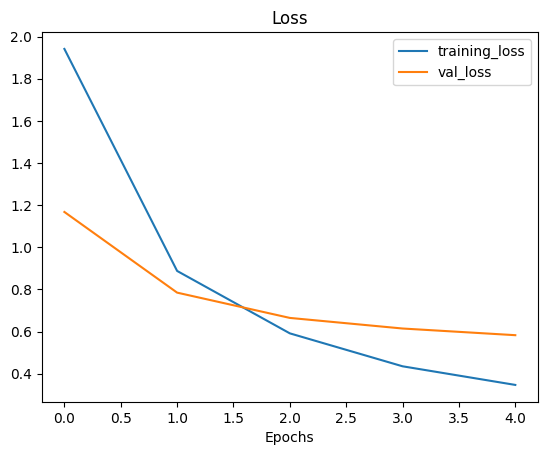

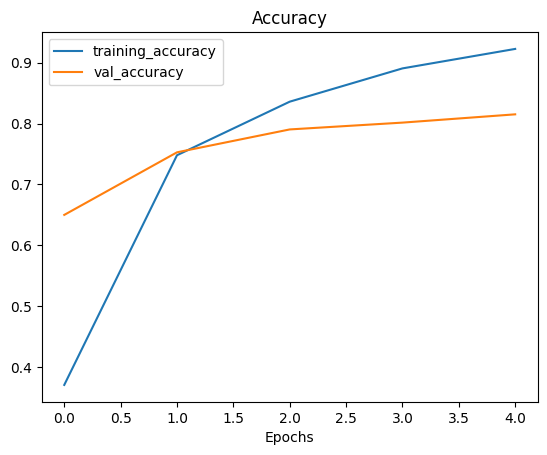

In [30]:
plot_loss_curves(resnet_history)

### EfficientNETB0 architecture

The setup is the same as before (the only difference is `model_url` parameter in creating model)

In [31]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 20s 548ms/step - loss: 1.9675 - accuracy: 0.3480 - val_loss: 1.4740 - val_accuracy: 0.6772
Epoch 2/5
24/24 [==============================] - 12s 499ms/step - loss: 1.2875 - accuracy: 0.7133 - val_loss: 1.0426 - val_accuracy: 0.7716
Epoch 3/5
24/24 [==============================] - 12s 496ms/step - loss: 0.9648 - accuracy: 0.7907 - val_loss: 0.8426 - val_accuracy: 0.8016
Epoch 4/5
24/24 [==============================] - 12s 499ms/step - loss: 0.7929 - accuracy: 0.8307 - val_loss: 0.7435 - val_accuracy: 0.8156
Epoch 5/5
24/24 [==============================] - 12s 496ms/step - loss: 0.6814 - accuracy: 0.8573 - val_loss: 0.6815 - val_accuracy: 0.8220


EfficientNet model has a little bit higher accuracy than ResNet model. It also seems to have less tendency to overfitting.

In [32]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


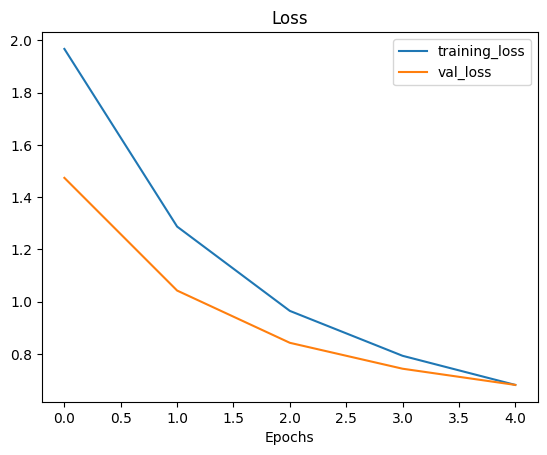

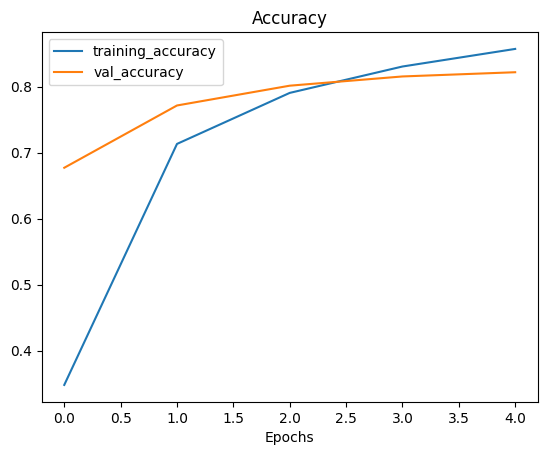

In [33]:
plot_loss_curves(efficientnet_history)

### MobileNet V1 architecture

Same as with the last one: The setup is the same as before (the only difference is `model_url` parameter in creating model)

In [34]:
# Create model
mobilenet_model = create_model(model_url=mobilenet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
mobilenet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 14s 508ms/step - loss: 2.5201 - accuracy: 0.2093 - val_loss: 1.8822 - val_accuracy: 0.3276
Epoch 2/5
24/24 [==============================] - 11s 486ms/step - loss: 1.6200 - accuracy: 0.4453 - val_loss: 1.3490 - val_accuracy: 0.5368
Epoch 3/5
24/24 [==============================] - 11s 491ms/step - loss: 1.1980 - accuracy: 0.6173 - val_loss: 1.0915 - val_accuracy: 0.6536
Epoch 4/5
24/24 [==============================] - 12s 503ms/step - loss: 0.9309 - accuracy: 0.7093 - val_loss: 0.9060 - val_accuracy: 0.7112
Epoch 5/5
24/24 [==============================] - 11s 483ms/step - loss: 0.7752 - accuracy: 0.7787 - val_loss: 0.8130 - val_accuracy: 0.7484


MobileNet V1 resulted in good accuracy score, much better than with the models built from scratch, but it's accuracy is smaller than EfficientNet and ResNet models' accuracy scores.

In [35]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 768)               1832976   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                7690      
                                                                 
Total params: 1840666 (7.02 MB)
Trainable params: 7690 (30.04 KB)
Non-trainable params: 1832976 (6.99 MB)
_________________________________________________________________


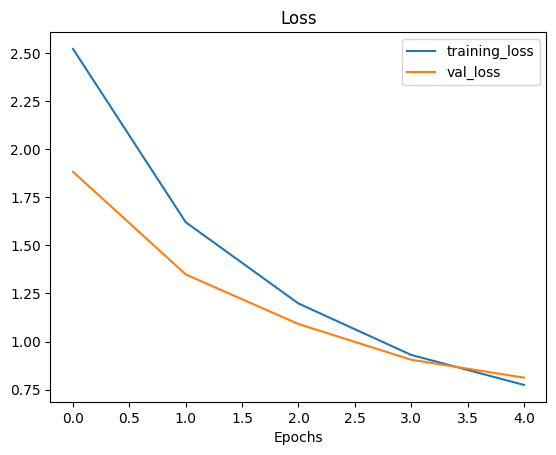

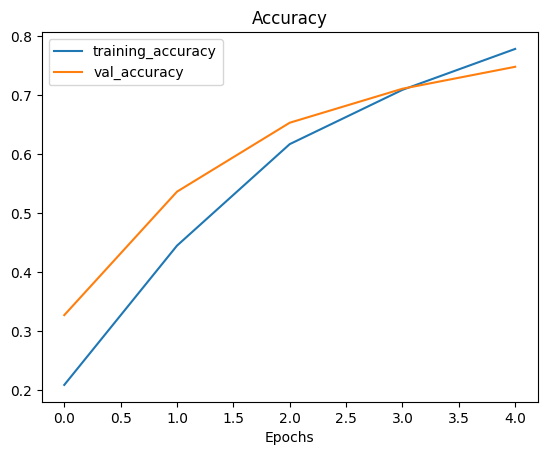

In [36]:
plot_loss_curves(mobilenet_history)

# Fine-Tuning the models

As a base model for further experiments I will use **EfficientNet** model architecture, since it resulted in the highest validation accuracy and the least tendency to overfitting.

Now I will to modify pre-trained model to be more suitable for the data.

For that I will use Keras Functional API and same as in the previous example I will use a smaller dataset for experiments (10%).

I will also use data augmentation to make the dataset more diverse.

Experiments of these phase are:
* Model 0: The base model (same as above) built using Keras Functional API
* Model 1: Feature Extraction model with data augmentation
* Model 2: A fine-tuned model (trained on 10%)

## Downloading the data

In previous projects of this series and in the first stage of this project I used `ImageDataGenerator` class to load the data into TensorFlow compatible format.

Now I will use `tf.keras.utils.image_dataset_from_directory()`, since it creates `tf.data.Dataset` object, and its API is faster to work with for larger datasets.

In [37]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10p,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

# I will call test set 'test_data_10_percent' for clarity, however it icludes all the test images
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [38]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [39]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_wings',
 'club_sandwich',
 'donuts',
 'french_fries',
 'hamburger',
 'hot_dog',
 'onion_rings',
 'pizza',
 'sushi',
 'tacos']

## Model 0: The base model

Now I will do the following steps:
* use `tf.keras.applications` module which contains a series of already trained (on ImageNet) computer vision problems and Keras Functional API,
* instantiate a pre-traied base model ***EfficientNetV2B0*** from `tf.keras.applications.efficientnet_v2`.
* set `include_top` to `False`, `trainable` to `False`.
* define an input layer, pass the inputs to the base model,
* transform modep output tensor (by using `GlobalAveragePooling2d` or `GlobalMaxPooling2d`, I'll use first one),
* create an output activation layer using `Dense()`
* combine the inputs and outputs layer using `Model()`
* compile the model and fit the model

In [40]:
from keras.src.backend import categorical_crossentropy
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

# If I used model that required rescaling, I would do this here for faster convergence, by:
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
# pass the inputs
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")
# aggregate the most important information and reduce the number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")
# create output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
# combine the inputs with the outputs
model_0 = tf.keras.Model(inputs, outputs)
# compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])
# fit the model
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25*len(test_data_10_percent)),
                              callbacks=[create_tensorboard_callback("transfer_learning", "10p_model_0_feature_extract")])

24274472/24274472 [==============================] - 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10p_model_0_feature_extract/20231207-141924
Epoch 1/5
24/24 [==============================] - 13s 139ms/step - loss: 1.9009 - accuracy: 0.4080 - val_loss: 1.2943 - val_accuracy: 0.7895
Epoch 2/5
24/24 [==============================] - 2s 84ms/step - loss: 1.1436 - accuracy: 0.7720 - val_loss: 0.8479 - val_accuracy: 0.8536
Epoch 3/5
24/24 [==============================] - 2s 83ms/step - loss: 0.8199 - accuracy: 0.8213 - val_loss: 0.6308 - val_accuracy: 0.8964
Epoch 4/5
24/24 [==============================] - 2s 83ms/step - loss: 0.6596 - accuracy: 0.8507 - val_loss: 0.5303 - val_accuracy: 0.9062
Epoch 5/5
24/24 [==============================] - 2s 84ms/step - loss: 0.5657 - accuracy: 0.8587 - val_loss: 0.5025 - val_accuracy: 0.8882


The model after fitting showed a very close (and very good) result to the result of the base model in the previous stage since the architecture inside remained unchanged.

For better understanding I will print the layers of the base_model (all the layers are frozen and are not trainable)

In [41]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

I will also print the summary of the whole model

In [42]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


I will also plot the model's training curves same as in the previous step of the project.

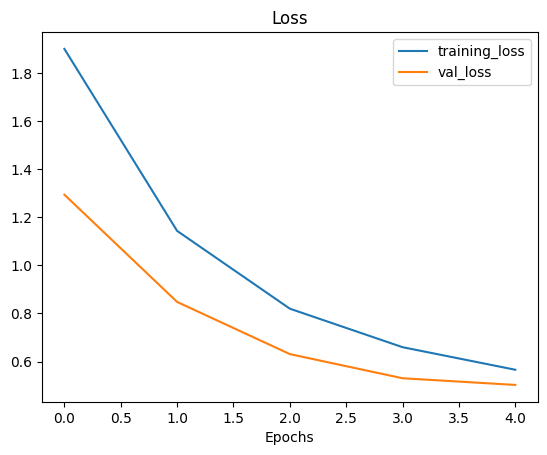

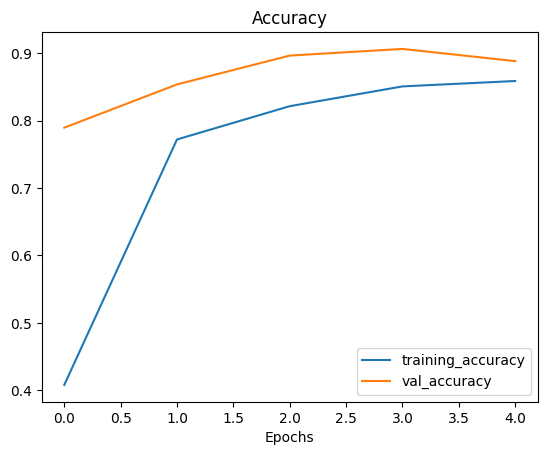

In [43]:
plot_loss_curves(history_model_0)

## Model 1. Feature Extraction model with data augmentation

Adding data augmentation. Previously I used `ImageDataGenerator` class to augment the images. Now I will include the data augmentation into the model's architecture creating a dedicated data augmentation layer. This way preprocessing of the images happens on the GPU and only during training, which makes exporting the model easier, since the data augmentation will be included.

For data augmentation I will create a Keras Sequential model consisting of the following transformations: `RandomFlip`, `RandomRotation`, `RandomZoom`, `RandomHeight` (height shifting), `RandomWidth` (width shifting). *(If I used another model than EfficientNetV2B0 that does not rescale by itself I would also add `Rescaling` (normalizing the image pixel values))*

In [44]:
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)],
    name="data_augmentation")

Before training the model I will try to visualize the augmentation on some sample image from the dataset

(-0.5, 608.5, 591.5, -0.5)

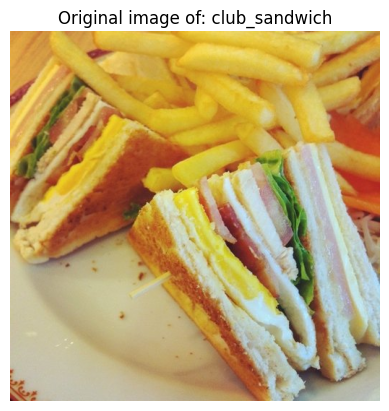

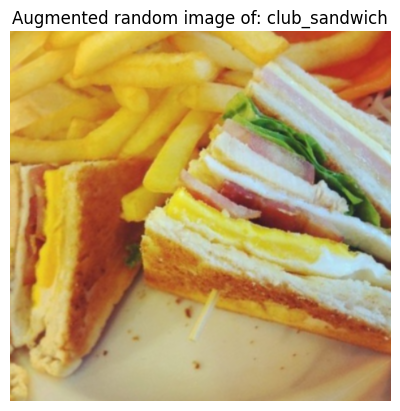

In [45]:
# choose and class and an image
target_class = random.choice(train_data_10_percent.class_names)
target_dir = train_dir_10p + "/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
# read the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original image of: {target_class}")
plt.axis(False);

# augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # normalize after augmention
plt.title(f"Augmented random image of: {target_class}")
plt.axis(False)

Now I will build the model with Keras Functional API with the architecture similar to the previous one, but this time I will add data augmentation model as a layer after the input layer

In [68]:
from tensorflow.keras import layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])

model_1_history = model_1.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25*len(test_data_10_percent)),
                              callbacks=[create_tensorboard_callback("transfer_learning", "10p_model_1_feature_extract_data_augmentation")])

Saving TensorBoard log files to: transfer_learning/10p_model_1_feature_extract_data_augmentation/20231207-145108
Epoch 1/5
24/24 [==============================] - 13s 226ms/step - loss: 2.0281 - accuracy: 0.3453 - val_loss: 1.4849 - val_accuracy: 0.6957
Epoch 2/5
24/24 [==============================] - 5s 178ms/step - loss: 1.3780 - accuracy: 0.6840 - val_loss: 1.0278 - val_accuracy: 0.8289
Epoch 3/5
24/24 [==============================] - 4s 174ms/step - loss: 1.0777 - accuracy: 0.7560 - val_loss: 0.7862 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 4s 143ms/step - loss: 0.9275 - accuracy: 0.7640 - val_loss: 0.6571 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 3s 134ms/step - loss: 0.8033 - accuracy: 0.7947 - val_loss: 0.5944 - val_accuracy: 0.8684


In [69]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

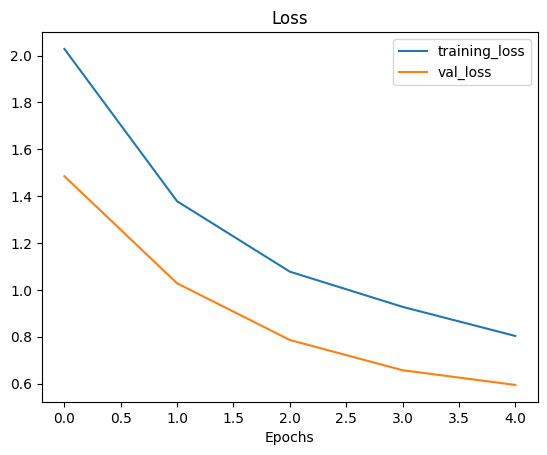

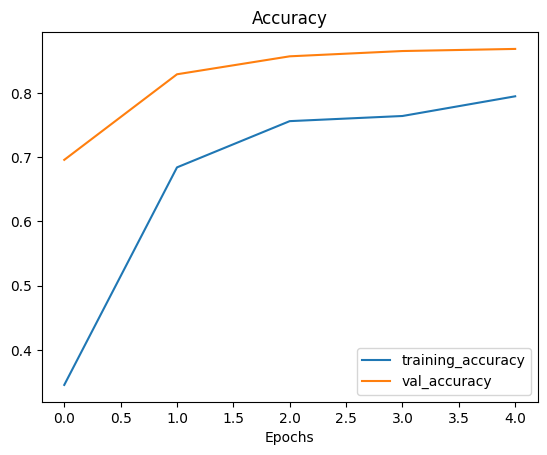

In [70]:
plot_loss_curves(model_1_history)

## Model 2: A fine-tuned model (10% Data)

I will use the same base model as before, but now I will unfreez sthe top layers that are closest to the top.

*Fine-tuning usually works better after training a feature extraction model for a few epochs with large amounts of data*

In [71]:
model_1.layers

In [72]:
for layer_number, layer in enumerate(model_1.layers):
  print(f"Layer number: {layer_number} | layer name: {layer.name} | Trainable? {layer.trainable}")

Layer number: 0 | layer name: input_layer | Trainable? True
Layer number: 1 | layer name: data_augmentation | Trainable? True
Layer number: 2 | layer name: efficientnetv2-b0 | Trainable? False
Layer number: 3 | layer name: global_average_pooling_layer | Trainable? True
Layer number: 4 | layer name: output_layer | Trainable? True


In [73]:
model_1_base_model = model_1.layers[2]
model_1_base_model.name

'efficientnetv2-b0'

The number of trainable layers in the base model:

In [74]:
print(len(model_1_base_model.trainable_variables))

0


All layers in `EfficientNetV2B0` are frozen. Now I will unfreeze the top 10 layers and continue training the model for another 5 epochs.

First I will unfreeze the entire model and then I will freeze last 10 layers by looping through them

In [75]:
model_1_base_model.trainable = True

for layer in model_1_base_model.layers[:-10]:
  layers.trainable = False

# recompile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = Adam(learning_rate = 0.0001),  # 10 times lower for fine-tuning
                metrics = ["accuracy"])

I will check which laters are trainable

In [76]:

print(f"The total nunmber of layers in the base model is: {len(model_1_base_model.layers)}. The trainable are:")
for layer_number, layer in enumerate(model_1_base_model.layers):
  if layer.trainable == True:
    print(layer_number, layer.name, layer.trainable)


The total nunmber of layers in the base model is: 270. The trainable are:
0 input_3 True
1 rescaling_2 True
2 normalization_2 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expa

In [77]:
print(f"The nunmber of trainable layers in the model: {len(model_1.trainable_variables)}.")

The nunmber of trainable layers in the model: 243.


Now I will begin fine-tuning, which starts on the epoch 5, since I continue training the model from place where the previous one finished.

In [78]:
fine_tune_epochs = 10

model_2_fine_tuned_history = model_1.fit(train_data_10_percent,
                                 epochs = fine_tune_epochs,
                                 validation_data = test_data_10_percent,
                                 initial_epoch = model_1_history.epoch[-1],
                                 validation_steps = int(0.25*len(test_data_10_percent)),
                                 callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231207-145138
Epoch 5/10
24/24 [==============================] - 54s 586ms/step - loss: 0.6186 - accuracy: 0.8067 - val_loss: 0.3582 - val_accuracy: 0.8997
Epoch 6/10
24/24 [==============================] - 12s 481ms/step - loss: 0.3475 - accuracy: 0.9027 - val_loss: 0.2633 - val_accuracy: 0.9211
Epoch 7/10
24/24 [==============================] - 11s 440ms/step - loss: 0.2214 - accuracy: 0.9253 - val_loss: 0.2395 - val_accuracy: 0.9227
Epoch 8/10
24/24 [==============================] - 10s 404ms/step - loss: 0.1180 - accuracy: 0.9720 - val_loss: 0.3055 - val_accuracy: 0.9013
Epoch 9/10
24/24 [==============================] - 8s 336ms/step - loss: 0.1380 - accuracy: 0.9587 - val_loss: 0.2628 - val_accuracy: 0.9178
Epoch 10/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0727 - accuracy: 0.9827 - val_loss: 0.2667 - val_accuracy: 0.9227


In [79]:
results_fine_tune_10_percent = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 2s 28ms/step - loss: 0.3118 - accuracy: 0.9112


Now I wil import the function from the `food_helper_functions` that compares two historys (Compares two TensorFlow model History objects), so I can compare the perfomance of the model before and after fine tuning

In [80]:
from food_helper_functions import compare_historys

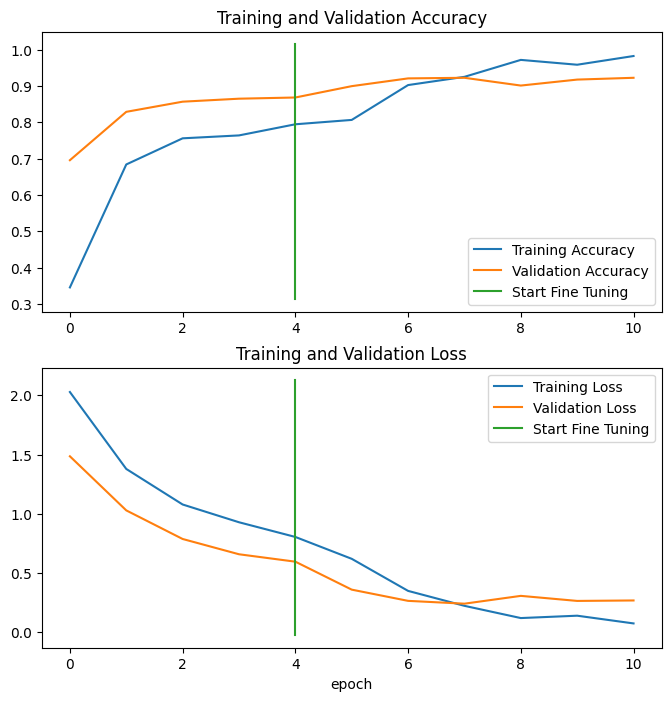

In [81]:
compare_historys(original_history = model_1_history,
                 new_history = model_2_fine_tuned_history,
                 initial_epochs=5)

After fine-tuning model seems to keep increasing the accuracy, but it also starts overfitting closer to the end. Last model has the highest accuracy score across all the models in this project.